In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from sklearn.feature_selection import f_classif, SelectKBest

## Predecir el coste del seguro médico de una persona



In [78]:
df = pd.read_csv('/workspaces/marcoakai_machine_learning/data/raw/medic.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Diccionario de variables

age: Edad del beneficiario (numérico)

sex: Género (categórico)

bmi: Índice de masa corporal (numérico)

children: Número de dependientes (numérico)

smoker: Fumador o no (categórico)

region: Región de residencia en EE.UU. (categórico)

charges: Coste del seguro médico (numérico, variable objetivo)

# Calidad de los datos

In [79]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [80]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Resultado:

No existen valores nulos

Tipos de datos correctos

Dataset apto para análisis

## Duplicados

In [81]:
df.duplicated().sum()
df = df.drop_duplicates().reset_index(drop=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


## Análisis descriptivo

In [82]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


Observaciones clave:

Edad media ≈ 39 años

BMI medio ≈ 30 → población con tendencia al sobrepeso

El coste del seguro tiene alta dispersión y presencia de outliers

# Análisis exploratorio 

### Distribución de variables numéricas

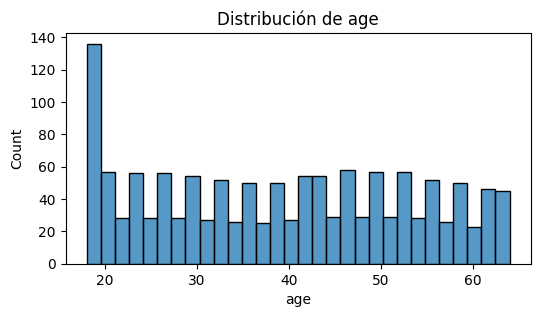

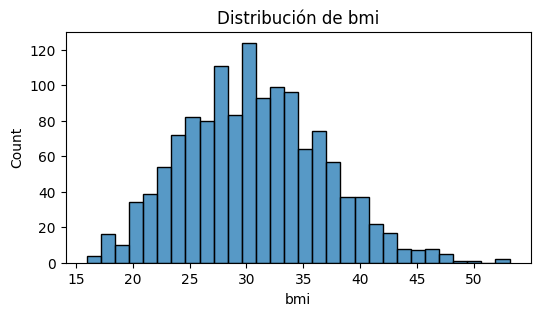

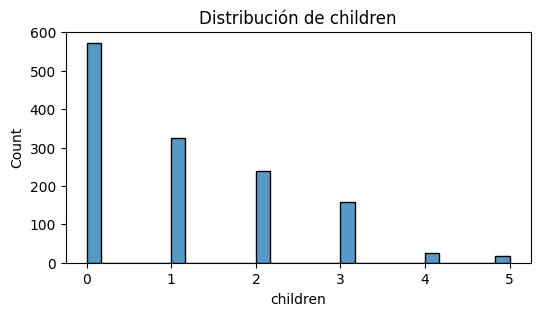

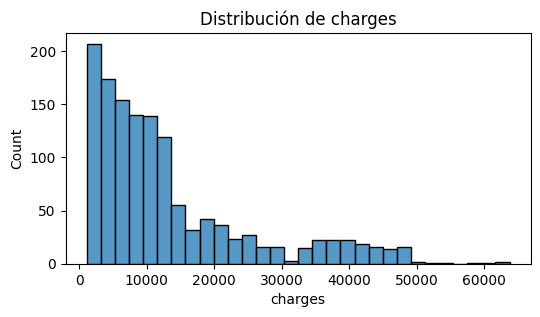

In [83]:
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], bins=30)
    plt.title(f'Distribución de {col}')
    plt.show()

### Boxplots (detección de outliers)

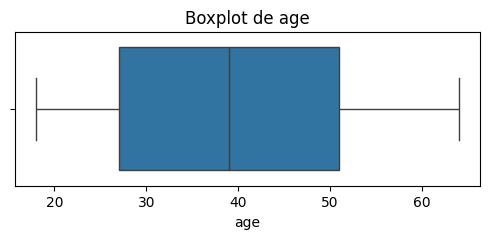

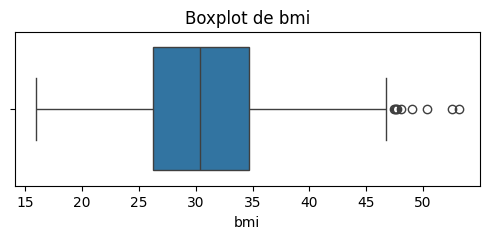

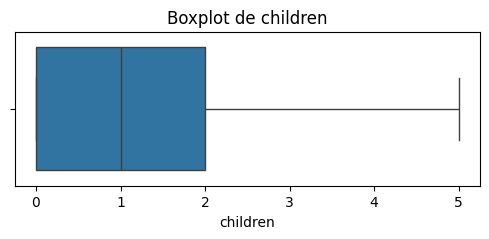

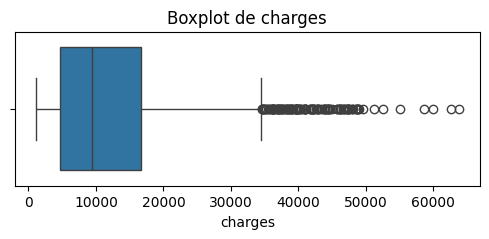

In [84]:
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

Conclusión:
Los outliers en charges representan casos reales de alto riesgo, por lo que no se eliminan.

## Análisis multivariante

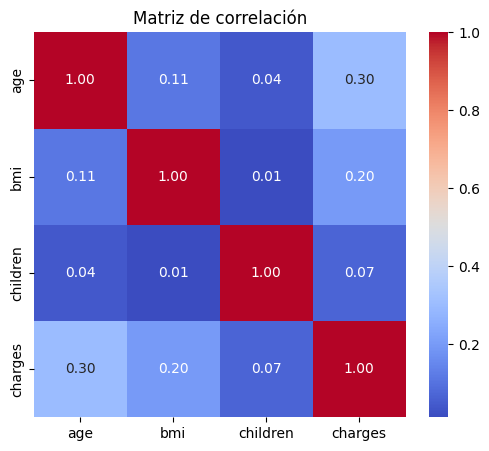

In [85]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

Correlación moderada entre age, bmi y charges

### Preparación para modelado

SPLIT


In [86]:

X = df.drop(["charges"], axis=1)
y = df["charges"]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

SCALING Y ENCODING

In [87]:
categorical_cols = ['sex', 'smoker', 'region']

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoder.fit(X_train[categorical_cols])

,categories,'auto'
,drop,'first'
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [88]:
X_train_ohe = pd.DataFrame(encoder.transform(X_train[categorical_cols]),
                           columns=encoder.get_feature_names_out(categorical_cols),
                           index=X_train.index)

X_test_ohe = pd.DataFrame(encoder.transform(X_test[categorical_cols]),
                          columns=encoder.get_feature_names_out(categorical_cols),
                          index=X_test.index)
X_train_ohe, X_test_ohe 

(      sex_male  smoker_yes  region_northwest  region_southeast  \
 1153       0.0         0.0               1.0               0.0   
 1100       1.0         0.0               0.0               0.0   
 661        0.0         0.0               0.0               0.0   
 147        0.0         0.0               0.0               1.0   
 534        1.0         0.0               0.0               1.0   
 ...        ...         ...               ...               ...   
 1198       0.0         0.0               0.0               0.0   
 837        0.0         0.0               0.0               0.0   
 1144       1.0         0.0               1.0               0.0   
 275        0.0         0.0               0.0               0.0   
 1322       0.0         1.0               0.0               1.0   
 
       region_southwest  
 1153               0.0  
 1100               1.0  
 661                0.0  
 147                0.0  
 534                0.0  
 ...                ...  
 1198       

In [89]:
X_train_num = X_train.drop(columns=categorical_cols)
X_test_num = X_test.drop(columns=categorical_cols)

X_train_final = pd.concat([X_train_num, X_train_ohe], axis=1)
X_test_final = pd.concat([X_test_num, X_test_ohe], axis=1)

X_train_final, X_test_final

(      age     bmi  children  sex_male  smoker_yes  region_northwest  \
 1153   48  27.930         4       0.0         0.0               1.0   
 1100   53  28.600         3       1.0         0.0               0.0   
 661    32  31.540         1       0.0         0.0               0.0   
 147    51  37.730         1       0.0         0.0               0.0   
 534    64  40.480         0       1.0         0.0               0.0   
 ...   ...     ...       ...       ...         ...               ...   
 1198   31  25.800         2       0.0         0.0               0.0   
 837    35  23.465         2       0.0         0.0               0.0   
 1144   52  32.775         3       1.0         0.0               1.0   
 275    47  26.600         2       0.0         0.0               0.0   
 1322   42  40.370         2       0.0         1.0               0.0   
 
       region_southeast  region_southwest  
 1153               0.0               0.0  
 1100               0.0               1.0  
 6

## Escalado de variables

In [90]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Modelado

## Modelo base: Regresión Lineal

In [91]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_pred

array([36892.49614029, 34168.09159298,  9195.71507812, 32210.41031587,
       39313.60683748,  4012.004917  , 28691.56499074, 37666.63632999,
       35980.45154431, 31639.16821692,  1430.53568058,  2463.38279908,
       11448.65836799, 10897.32895292, 15295.25059704, 12421.3906986 ,
       12247.45702536, 11468.33091204,  9243.16392878, 28030.57838652,
       35920.14407393,  8838.52370185,  2730.76094345, 11388.43259215,
       15629.16280272,  2278.29225451, 27580.07876686, 11011.39121096,
        5205.45134441, 26748.58674546,  8303.92012013, 12513.08998458,
       11986.10696356,  7747.45484969, 13061.90387521,  1729.89062149,
        9335.41046166, 33739.96654751, 15738.3668279 ,  3015.3908888 ,
        4471.57126257, 35477.33963578, 11411.30774358, 34321.40571715,
       25874.23775581, 32561.01416369, 24078.88785481,  5362.45417378,
       10070.42587756, 25671.77608512, 11193.24999062,  1718.44865037,
       13051.28084505,  6087.66189977,  3148.97378608, 16142.3433548 ,
      

### Evaluación

In [92]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

rmse, r2


(6397.118945051255, 0.7165313808459939)

El modelo explica aproximadamente el 71% de la variabilidad del coste del seguro.

Modelos regularizados

Ridge Regression

In [93]:
y_pred_ridge = ridge.predict(X_test_scaled)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_ridge, r2_ridge

(6396.975069705894, 0.7165441314880249)

Lasso Regression

In [95]:
lasso = Lasso(alpha=0.1, max_iter=300)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_lasso, r2_lasso

(6397.093346163523, 0.7165336495131552)

# Conclusiones finales

El factor más influyente en el coste del seguro es ser fumador

Edad y BMI también contribuyen al aumento del precio